# A minimum-cost bicing flow to guarantee a number of bicycles and docks in every station

Barcelona bicing users have a natural tendency of preferring downward-sloping streets. This creates an unbalanced distribution of bicycles, concentrating most of them in the lower part of the city. This phenomenon is often compensated by a counterflow generated by the trucks that transport bicycles in the opposite direction.

We would like to estimate the cost of transporting bicycles to compensate unbalanced distributions. In this exercise, we will consider a simplified version of the problem with the following assumptions:
* We want to guarantee a minimum number of available bicycles and empty docks at every station of the city. For that, we will need to transfer bicycles from certain stations to other stations.
* The cost of moving a bicycle is proportional to the distance that it has to travel across the edges of the current geometric graph of your application. This model is not realistic since we know that the cost of transporting 10 bicycles is not 10 times the cost of transporting one bicycle. However, this unrealistic model can still give a good estimation and make the computation affordable with the functions provided by the `NetworkX` package.
* **Goal:** to determine how many bicycles must be transfered such that the minimum requirements for bicycles and docks are met and the transportation cost is minimized.

As an example, your new command should have the following syntax:

```/distribute 4 3```

indicating that we want to guarantee 4 bicycles and 3 empty docks at each bicing station. 
The output of the command should be something like this:

```Total cost of transferring bicycles: 109.63 km
3 -> 6: 3 bicycles
345 -> 412: 2 bicycles
...
```

where `3->6` represents the edge between stations with id 3 and 6, respectively. Please, do not report the edges that transport 0 bicycles.

**Note:** Notice that `/distribute 0 0` should not generate any transportation and the cost should be `0 km`. Notice also that `/distribute 100 100` might be unfeasible. This situation should also be reported properly.

Below you will find some hints on how to implement this part of the project. In fact, very little has to be done to complete the project.

In [3]:
import pandas as pd
import networkx as nx
import itertools as it
from haversine import haversine
from pandas import DataFrame
from IPython.display import display
from PIL import Image

### Data acquisition
The DataFrame `stations` contains the location of the bicing stations. The DataFrame `bikes` reports the number of available bikes and docks at each station (in real time!). The stations are identified by their indices.

In [4]:
url_info = 'https://api.bsmsa.eu/ext/api/bsm/gbfs/v2/en/station_information'
url_status = 'https://api.bsmsa.eu/ext/api/bsm/gbfs/v2/en/station_status'
stations = DataFrame.from_records(pd.read_json(url_info)['data']['stations'], index='station_id')
bikes = DataFrame.from_records(pd.read_json(url_status)['data']['stations'], index='station_id')

#### Let us keep only the interesting columns

In [5]:
nbikes = 'num_bikes_available'
ndocks = 'num_docks_available'
bikes = bikes[[nbikes, ndocks]] # We only select the interesting columns
bikes

,num_bikes_available,num_docks_available
station_id,,
1,4,24
2,6,17
3,16,11
4,12,7
5,37,0
6,25,13
7,16,11
8,17,8
9,19,7


#### Let us print the total number of bikes and docks in the city (just fo curiosity)

In [6]:
TotalBikes = bikes[nbikes].sum()
TotalDocks = bikes[ndocks].sum()
print("Total number of bikes:", TotalBikes)
print("Total number of docks:", TotalDocks)

Total number of bikes: 4782
Total number of docks: 5273


### Parametres of the problem

In [7]:
radius = 0.6      # Radius for the geometric graph (you will have to use your current geometric graph)
requiredBikes = 1 # Required number of bikes (this will be a parameter of your command)
requiredDocks = 1 # Required number of docks (this will be a parameter of your command)

### Stations with a deficit of bikes or docks

Just fo curiosity.

In [8]:
bikes.loc[(bikes[nbikes] < requiredBikes) | (bikes[ndocks] < requiredDocks)]

,num_bikes_available,num_docks_available
station_id,,
5,37,0
11,20,0
12,25,0
13,53,0
14,25,0
15,21,0
17,42,0
18,0,27
21,0,21


### Graph model for the flow problem

For simplicity, we suggest this model for the problem, although another one would also be possible. See the details below.

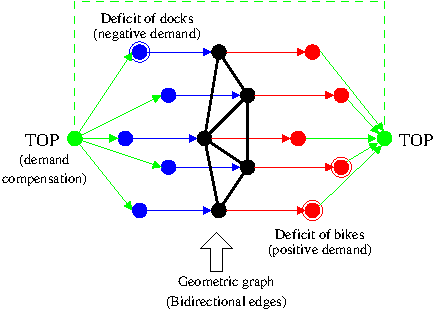

In [9]:
display(Image.open('flow.png'))

### Graph model
* Every station is represented by three nodes (blue, black, red).
* The geometric graph, with bidirectional edges, is represented with the black nodes and edges.
* The blue->black edges represent the `donation` of bikes to the network.
* The black->red edges represent the `reception` of bikes from the network.
* Some stations may have a deficit of bikes (double circle in red nodes). These stations must have a positive demand of bicycles.
* Some stations may have a deficit of free docks (double circle in blue nodes). These stations must have a negative demand of bicycles.
* For those nodes that meet the constraints (no deficit of bikes or docks), the flow must be zero. All bikes donated by the node (blue->black edge) are compensated by the free docks received by the same node (green->blue edges). Similarly, all bikes received by the node (black->red edges) are compensated by the docks donated by the node (red->green edges). Notice the duality between bikes and slots: the absence of a bicycle implies a free docks, in such a way that `bikes + free docks` is an invariant at each station.
* The __TOP__ node is used to compensate the demand of bikes/docks (the sum of demands must be zero). Notice that the __TOP__ node has been duplicated to simplify the drawing of the graph: the two green nodes are the same.

#### Attributes of the graph

Here is your main contribution in this part of the project. The previous picture shows how to define the skeleton of the graph model. However, it does not define the attributes of the nodes and edges. Here is where you have to complete the definition of the graph.

We recommend to use the `network_simplex` function of `NetworkX`. Please, read the specification and define the attributes of the graph accordingly.

In [10]:
url_info = 'https://api.bsmsa.eu/ext/api/bsm/gbfs/v2/en/station_information'
url_status = 'https://api.bsmsa.eu/ext/api/bsm/gbfs/v2/en/station_status'
stations = DataFrame.from_records(pd.read_json(url_info)['data']['stations'], index='station_id')
bikes = DataFrame.from_records(pd.read_json(url_status)['data']['stations'], index='station_id')
G = nx.DiGraph()
G.add_node('TOP') # The green node
demand = 0
estaciones_malas = []
for st in bikes.itertuples():
    idx = st.Index
    if idx not in stations.index: 
        estaciones_malas.append(idx)
        continue
    stridx = str(idx)
    
    # The blue (s), black (g) and red (t) nodes of the graph
    s_idx, g_idx, t_idx = 's'+stridx, 'g'+stridx, 't'+stridx
    G.add_node(g_idx)
    G.add_node(s_idx)
    G.add_node(t_idx)
    
    b, d = st.num_bikes_available, st.num_docks_available
    req_bikes = max(0, requiredBikes - b)
    req_docks = max(0, requiredDocks - d)
    
    # Some of the following edges require attributes
    G.add_edge('TOP', s_idx)
    G.add_edge(t_idx, 'TOP')

    G.add_edge(s_idx, g_idx, capacity = max(0, b-requiredBikes))
    G.add_edge(g_idx, t_idx, capacity = max(0, d-requiredDocks))
    '''
    G.add_edge(s_idx, g_idx)
    G.add_edge(g_idx, t_idx)
    '''
    
    if req_bikes > 0:
        demand += req_bikes
        G.nodes[t_idx]['demand'] = req_bikes
        # something else must be done here (demand?)
    elif req_docks > 0:
        demand -= req_docks
        G.nodes[s_idx]['demand'] = -req_docks
        # something else must be done here (demand?)
estaciones_malas

[42, 179, 223, 228, 256, 269, 345, 351, 352, 404, 406]

### Demand compensation
Compensate the demand with the TOP node

In [11]:
G.nodes['TOP']['demand'] = -demand
# Something must be defined here

### Bidirectional edges of the geometric graph (black nodes and edges)
The graph is constructed using a _quadratic_ algorithm. A more efficient approach could be used instead. Here you should _copy_ the edges and information of your geometric graph.

**Note:** For convenience, the distances are converted into meters and forced to be integer. This is a requirement for the correct execution of the Network Simplex algorithm.

In [12]:
for idx1, idx2 in it.combinations(stations.index.values, 2):
    coord1 = (stations.at[idx1, 'lat'], stations.at[idx1, 'lon'])
    coord2 = (stations.at[idx2, 'lat'], stations.at[idx2, 'lon'])
    dist = haversine(coord1, coord2)
    if dist <= radius:
        dist = int(dist*1000)
        # The edges must be bidirectional: g_idx1 <--> g_idx2
        G.add_edge('g'+str(idx1), 'g'+str(idx2), weight=dist)
        G.add_edge('g'+str(idx2), 'g'+str(idx1), weight=dist)
        
print('Graph with', G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges.")

Graph with 1183 nodes and 5444 edges.


### Min cost flow

The minimum cost flow is calculated by the 
[Network Simplex](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.network_simplex.html#networkx.algorithms.flow.network_simplex)
algorithm.

Indeed, the reported solution is **incorrect** since no attributes have been defined.

In [13]:
err = False

try:
    flowCost, flowDict = nx.network_simplex(G)

except nx.NetworkXUnfeasible:
    err = True
    print("No solution could be found")

except:
    err = True
    print("***************************************")
    print("*** Fatal error: Incorrect graph model ")
    print("***************************************")

if not err:
    print("The total cost of transferring bikes is", flowCost/1000, "km.")
    # We update the status of the stations according to the calculated transportation of bicycles
    for src in flowDict:
        if src[0] != 'g': continue
        idx_src = int(src[1:])
        for dst, b in flowDict[src].items():
            if dst[0] == 'g' and b > 0:
                idx_dst = int(dst[1:])
                print(idx_src, "->", idx_dst, " ", b, "bikes, distance", G.edges[src, dst]['weight'])
                bikes.at[idx_src, nbikes] -= b
                bikes.at[idx_dst, nbikes] += b 
                bikes.at[idx_src, ndocks] += b 
                bikes.at[idx_dst, ndocks] -= b

No solution could be found


Let us double check that we still have the same number of bikes and docks

In [15]:
TotalBikes = bikes[nbikes].sum()
TotalDocks = bikes[ndocks].sum()
print("Total number of bikes:", TotalBikes)
print("Total number of docks:", TotalDocks)  

Total number of bikes: 4781
Total number of docks: 5274


#### Stations with deficit of bikes or docks after transferring the bicycles
This list should be empty if the problem is feasible. If not, something went wrong when solving the problem.

In [16]:
bikes.loc[(bikes[nbikes] < requiredBikes) | (bikes[ndocks] < requiredDocks)]

,is_charging_station,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_available_types,num_docks_available,status
station_id,,,,,,,,,
5,True,1,1,1,1559808366,37,"{'mechanical': 37, 'ebike': 0}",0,IN_SERVICE
11,True,1,1,1,1559808331,20,"{'mechanical': 20, 'ebike': 0}",0,IN_SERVICE
12,True,1,1,1,1559808403,25,"{'mechanical': 25, 'ebike': 0}",0,IN_SERVICE
13,True,1,1,1,1559808502,53,"{'mechanical': 49, 'ebike': 4}",0,IN_SERVICE
14,True,1,1,1,1559808422,25,"{'mechanical': 25, 'ebike': 0}",0,IN_SERVICE
15,True,1,1,1,1559808419,21,"{'mechanical': 20, 'ebike': 1}",0,IN_SERVICE
17,True,1,1,1,1559808361,42,"{'mechanical': 38, 'ebike': 4}",0,IN_SERVICE
18,True,1,1,1,1559808508,0,"{'mechanical': 0, 'ebike': 0}",27,IN_SERVICE
21,True,1,1,1,1559808319,0,"{'mechanical': 0, 'ebike': 0}",21,IN_SERVICE
